In [6]:
import pint

import numpy
    
import scipy

import random

import pandas as pd

from modsim import *

In [42]:
#Universal parameters
time_until_arrival = []

#Initialize rcv, ship, and arrival times for generate_trucks():
rcv_trucks_that_day = 6
shp_trucks_that_day = 30

init_arrival_time_min = 480
init_arrival_time_max = 1020


#Team Parameters
shp_team_no=2
rcv_team_no=2

#Check In Stage ----------------
#Bay is assigned
checkin_min = 5
checkin_max = 15

#Papers are checked on arrival
papers_check_min= 5
papers_check_max= 10
#-------------------------------


#Receiving Process Parameters ------
container_check_min = 10 #Check for damages and document state of container when it comes in
container_check_max = 30

unload_min = 60
unload_max = 120
#-----------------------------------

#Ship Process Params----------------
load_time_min = 40
load_time_max = 60
#-----------------------------------

#Exit Time Ship---------------------
paper_depart_min = 5
paper_depart_max = 15
strapdown_time_min = 30
strapdown_time_max = 60
#-----------------------------------

#Depart Time Rcv-------------------
paper_depart_min = 5
paper_depart_max = 15
#-----------------------------------


#Wait Time Variables-----------------
#Min Wait Time for Ship Truck: 43 mins not including strapdown(once loading is done, team is free, this is to help track team time)
#Max Wait time for Ship Truck: 85 mins not including strapdown or waiting on other trucks to finish
#Median Wait Time if no Teams Available: 42 mins (half of 85)
med_wait_shp_truck = 42

#Min time for Rcv Truck: 77 mins
#Max time for Rcv Truck: 190 mins
med_wait_rcv_truck = 113

init_arrival_time_min = 480
init_arrival_time_max = 1020



In [7]:
def truck_generation(shp_trucks_that_day,init_arrival_time_min, init_arrival_time_max):
    frame = TimeFrame(columns = ['Arrival_Time','Type','CheckIn_Complete',
                                 'Load_Complete','Strap_Complete','Departed','Waiting_on_Team_Duration','Total_Visit_Duration'])
    
    for i in range(shp_trucks_that_day):
        
        #initialize random arrival times
        frame.loc[i,'Arrival_Time'] = random.randint(init_arrival_time_min,init_arrival_time_max)
        
    frame['Type'] = 'Shipping'
    frame = frame.sort_values('Arrival_Time')
    frame = frame.reset_index(drop = True)
    frame = frame.fillna(0)
    return frame
                      

truckFrame = truck_generation(shp_trucks_that_day,init_arrival_time_min, init_arrival_time_max)


In [8]:
def team_generation(truckFrame,rcv_trucks_that_day,shp_trucks_that_day,rcv_team_no):
    # Dynamically generates a dictionary of dataframes that are named and created based on how many teams are set to be available
    # these dataframes are then returned. Subsequent function calls dependent on these dataframes access them by iterating of the names:
    # 'RcvTeam{}' and 'ShpTeam{}' where {} mark the index number of teams starting from 0. So if you have 2 shipping teams, the function
    # will create 'ShpTeam0' and ShpTeam1'
    
    rcv_team_frames = {}
    shp_team_frames = {}
    
    rcv_indexes = truckFrame[truckFrame['Type'] == 'Receiving'].index
    shp_indexes = truckFrame[truckFrame['Type'] == 'Shipping'].index
    
    for i in range(rcv_team_no):
        frame_name = f"RcvTeam{i}"  #generate the dynamic variable name
        rcv_team_frames[frame_name] = pd.DataFrame(columns = ['Occupied_Start','Occupied_End'],
                                          index = rcv_indexes,
                                          data = -1)
        
    for i in range(shp_team_no):
        frame_name = f"ShpTeam{i}"  #generate the dynamic variable name
        shp_team_frames[frame_name] = pd.DataFrame(columns = ['Occupied_Start','Occupied_End'],
                                          index = shp_indexes,
                                          data = -1)

    return (rcv_team_frames,shp_team_frames)
 
rcv_team_frames, shp_team_frames = team_generation(truckFrame,rcv_trucks_that_day,shp_trucks_that_day,rcv_team_no)

In [34]:
def check_shp_team(truckFrame,truck_index,arrival_time,shp_team_frames):
    #WIll check the ShpTeams generated by 'generate_teams()' to see if the team is Free
    #    handle round robin enforcement?
    # Cycles through shp_team_frames and pulls the most recent occupied time (sorted descending),
    #    if team is free, updates Occupied Times and truckFrames Load Complete column and breaks the loop
    #    if team is not free, loops to the next
    #    if both teams are still not free, calls 'find_next_truck_departure_time'
    
    
    found_free = False
    
    for i in range(len(shp_team_frames.keys())): #this chunk should return 

        occupy_time = shp_team_frames[f'ShpTeam{i}'].sort_values('Occupied_Start', ascending = False).head(1)
        #If the team is free, update their Occupied Times and the truckFrames Load Complete time
        
        is_within_range = (occupy_time['Occupied_Start'].values <= arrival_time) & (arrival_time <= occupy_time['Occupied_End'].values)
        
        if is_within_range == True:
            status = f'ShpTeam{i} OCCUPIED'
            print(status)
            found_free = False
        
        if is_within_range == False:
            shp_team_frames[f'ShpTeam{i}'].at[truck_index,'Occupied_Start'] = truckFrame.at[truck_index,'Arrival_Time']
            truckFrame.at[truck_index,'CheckIn_Complete'] = (truckFrame.at[truck_index,'Arrival_Time'] + random.randint(checkin_min,checkin_max))
            shp_team_frames[f'ShpTeam{i}'].at[truck_index,'Occupied_End'] = (truckFrame.at[truck_index,'CheckIn_Complete']
                                                                        + random.randint(load_time_min,load_time_max) + random.randint(paper_depart_min,paper_depart_max))
            print(shp_team_frames)
            truckFrame.at[truck_index,'Load_Complete'] = shp_team_frames[f'ShpTeam{i}'].at[truck_index,'Occupied_End']
            print(truckFrame[['Arrival_Time', 'Type', 'CheckIn_Complete', 'Load_Complete','Waiting_on_Team_Duration']])
            
            found_free = True
                
        if found_free == True:
            print(f'Found ShpTeam{i} to be free and will be assigned to Truck {truck_index}')
            break
            
            
        #If no teams were free during the truck's arrival time, call our function to determine when the next team will be free and it will update the values
    if found_free == False:
        print('Both teams are occupied, calling find_next_shp_truck_departure_time')
        find_next_shp_truck_departure_time(truck_index,arrival_time)
            
    return (shp_team_frames)

def check_rcv_team(truckFrame,truck_index,rcv_team_frames):
    for i in rcv_team_frames:
        status = rcv_team_frames[f'RcvTeam{i}'].at[truck_index,'Occupied_Start']
        if status == "FREE":
            shp_team_frames[f'RcvTeam{i}'].at[truck_index,'Occupied_Start']=truckFrame.at[i,'Arrival_Time']
            break
        else:
            print("Function check_rcv_team could not find 'FREE' in any team frames")

In [10]:
#removed truckFrame from arguments to see if it has access to the superior variables in the function
# this function's purpose is to find out when the next truck will leave that will allow a team to work on the next truck and update the metrics appropriately
# If I pass arrival_time and truck_type, assuming it has access to the truckFrame and team frames, I want it to look at the Load_Complete column where the Type 
# of truck is equivalent and find out when the next truck is leaving where the team's occupied time is in the range of the current truck's arrival time
# Find index of Teams that have their Occupied Times containing this truck's arrival

def find_next_shp_truck_departure_time(truck_index,arrival_time):
    smallest_value = float('inf')  # Initialize with a large value to ensure everything is deemed smaller for evaluation later
    smallest_dataframe = ""
    
    occupied_end_ship_frames = {}
    for i in range(len(shp_team_frames.keys())): #Create our list of dataframes for evaluation
        occ_frame_name = f"ShpTeam{i}"  #generate the dynamic variable name
        occupied_end_ship_frames[occ_frame_name] = shp_team_frames[f'ShpTeam{i}'].sort_values('Occupied_Start', ascending = False).head(1)
        
    
    
    for dataframe_name, dataframe in occupied_end_ship_frames.items(): #for each dataframe in the occupied_end_ship_frames list
        occupied_end_value = dataframe['Occupied_End'].values[0]  # Get the value from the first row of the 'Occupied_End' column, which should be the most recent truck assigned

        if occupied_end_value < smallest_value: #set out occupied_end_value smaller if it is smaller and catch the end value and dataframe name into variables
            smallest_value = occupied_end_value
            smallest_dataframe = dataframe_name
            

    #Updates need to happen to:
        #truckFrame
        #team frame
        
            shp_team_frames[smallest_dataframe].at[truck_index,'Occupied_Start'] = smallest_value + 5
            shp_team_frames[smallest_dataframe].at[truck_index,'Occupied_End'] = (smallest_value + random.randint(checkin_min,checkin_max)
                                                                        + random.randint(load_time_min,load_time_max) + random.randint(paper_depart_min,paper_depart_max))
            print(shp_team_frames)
            truckFrame.at[truck_index,'Load_Complete'] = shp_team_frames[smallest_dataframe].at[truck_index,'Occupied_End']
            truckFrame.at[truck_index,'CheckIn_Complete'] = (truckFrame.at[truck_index,'Arrival_Time'] + random.randint(checkin_min,checkin_max))
            truckFrame.at[truck_index,'Waiting_on_Team_Duration'] = shp_team_frames[smallest_dataframe].at[truck_index,'Occupied_Start'] - arrival_time
            print(truckFrame[['Arrival_Time', 'Type', 'CheckIn_Complete', 'Load_Complete']])

            print("Smallest value:", smallest_value)
            print("Smallest dataframe:", smallest_dataframe)

In [11]:
#Call-In Team Availability Section
#This part captures the time in which a truck has arrived, called in, and we are checking to see if a team and bay can be allocated:
# Create a state object for Teams, whenever a truck is assigned a bay, a check is made to see if a team is available.
#    state(shp_teams_avail=2, rcv_teams_avail=2,trucks_in_wait=0,trucks_in_bay=0,trucks_in_strap=0)
#    upon checkin, the state object is checked for availability, if there is, then it subtracts the team and uses checkin_min/max
#    if shp_teams_avail or rcv_teams_avail is 0, the code needs to add a wait time that is determined by when a team becomes available

#Truck State
# What states are the trucks in at any given point int he process?
# Waiting on Assignment: the time after calling in for bay assignment
# In-Bay/Loading: time spent in bay
# StrappingDown: time spent in strap stations

#How do I track metrics? Add to truckFrame, but I will have to pass that to call_in
#How do I update the trucks? with an update func(). The update function would need to update each truck in truckFrame.
#    If I had multiple update functions, what are they and waht would they do:
#    I assume all of them would be filling in values in our truckFrame, I could have one to represent each action
#    Truck Calling In, Warehouse Processing, Departure(?) I think really only two would be needed
#    How would I chain them together? I could call them by row to iterate by row, 

wh_State = State(shp_teams_avail=2, rcv_teams_avail=2,trucks_in_wait=0,trucks_in_bay=0,trucks_in_strap=0,truck_wait_instances=0)

   

def call_in(truckFrame,shp_team_frames,wh_State,checkin_min,checkin_max,papers_check_min,papers_check_max):
    for i in truckFrame.index: #run for each row in truckFrame
        
        truckFrame = truckFrame
        shp_team_frames = shp_team_frames
        wh_State = wh_State
        checkin_min = checkin_min
        checkin_max = checkin_max
        papers_check_min = papers_check_min
        papers_check_max = papers_check_max
        
        truck_index = i
        arrival_time = truckFrame.at[i,'Arrival_Time']
        
        
        
        ##Checking In Section ---- Truck calls in, teams are checked, bay assigned, papers checked
        ## Fills in truckFrame[i,'CheckIn_Complete']
        if truckFrame.at[i,'Type'] == 'Shipping': #If Truck is Shipping
            #Team Availability Check + CheckIn Time
            check_shp_team(truckFrame,truck_index,arrival_time,shp_team_frames) #Checks for an available team, updates team occupied times and truckFrames Load_Complete
                                                            #if no team available, calls find_next_departure_truck_time() and upates team occupied times and truckFrames Load_Complete based on that
            # takes arguments (truckFrame,truck_index,arrival_time,shp_team_frames)
            
            #whats left is updating CheckIn_Complete, Strap_Complete, Waiting_on_Team_Duartion, Total_Visit_Duration
            calculate_strap_departed_visitduration(truckFrame,truck_index)

            
            
#             #uncomment below line to revert
#             #if wh_State.shp_teams_avail==0: #If no team is available
#                 wh_State.trucks_in_wait +=1 #add to trucks_in_wait
#                 wh_State.truck_wait_instances+=1 #add to instances of waiting
#                 truckFrame.at[i,'WaitingYN'] = 1 #add to that trucks state that it waited
                
#                 #Commented lines below are the old version of checking for team completion using static values, comment departure_value line out and uncomment the two lines above to revert
#                 #truckFrame.at[i,'Waiting_on_Team_Duration'] += med_wait_shp_truck #add 42 minutes to the unnecessary wait time for that truck; may need a better way to do this
#                 #truckFrame.at[i,'CheckIn_Complete'] = truckFrame.at[i,'Arrival_Time'] + med_wait_shp_truck + random.randint(checkin_min,checkin_max) + random.randint(papers_check_min,papers_check_max)
#                 departure_value = find_next_truck_departure_time(truckFrame.at[i,'Arrival_Time'],truckFrame.at[i,'Type']) #function finds the next most soon truck to leave by checking the Team Occupy Frame
#                 truckFrame.at[i,'CheckIn_Complete'] = departure_value + random.randint(checkin_min,checkin_max) + random.randint(papers_check_min,papers_check_max)                
                
#             else: #if shipping team available, 
#                 wh_State.shp_teams_avail-=1 #subtract 1 from wh_State team
#                 wh_State.trucks_in_bay+=1 #add 1 to wh_State bay
#                 truckFrame.at[i,'CheckIn_Complete'] = truckFrame.at[i,'Arrival_Time'] + random.randint(checkin_min,checkin_max) + random.randint(papers_check_min,papers_check_max)
#             # Calculate Load Time, Strap, Departed, and Total Visit Duration
#             truckFrame.at[i,'Load_Complete'] = truckFrame.at[i,'CheckIn_Complete'] + random.randint(load_time_min,load_time_max) + random.randint(paper_depart_min,paper_depart_max)
#             # Once loading is complete, the wh_State can be updated to have teams available again
            
#             #Issue Im thinking about right now is that my script will never hit the scenario of shp_teams_avail==0 since by the time it completes it will always add 1.
#             #This is an issue because trucks will arrive at various times, to deal with this we could have it so that the script evaluates previous time marks
#                 #It'd have to check how many trucks arrived before that are the same type
#                 # Pull the departure time of the truck and set it as its start
#                 # Let's say there are 7 trucks before hand and 4 are shipping, I'd compare the departure time to current truck arrival time and if any are after
#                 #     my arrival, then I'd set current trucks loading time to the departure time of the last +10 min. I could calculate whether teams were occupied
#                 #     by looking at arrival/departure times
#                 # Accomplished above by two functions:
#                 # 1. check_shp_team()/check_rcv_team()
#                 # This code
#                 #creating 'find_next_truck_departure_value' that would pull the smallest departure value
                
#                 #What if there was a team state that showed when they were and weren't busy? First truck comes in, fills out its row, updates the team state on when
#                 #     that team was done with it. If there are two teams, how would it know which team to check? Checks both for a null value set to free
            
            
#             truckFrame.at[i,'Strap_Complete'] = truckFrame.at[i,'Load_Complete'] + random.randint(strapdown_time_min,strapdown_time_max)
#             truckFrame.at[i,'Departed'] = truckFrame.at[i,'Strap_Complete']
#             truckFrame.at[i,'Total_Visit_Duration'] = truckFrame.at[i,'Departed'] - truckFrame.at[i,'Arrival_Time']
            
            
#         else: #If Truck is Receiving
#             if wh_State.rcv_teams_avail==0: #check for receiving team availability
#                 wh_State.trucks_in_wait +=1 #add to trucks_in_wait
#                 wh_State.truck_wait_instances+=1 #add to instances of waiting
#                 truckFrame.at[i,'WaitingYN'] = 1 #add to that trucks state that it is waiting
#                 truckFrame.at[i,'Waiting_on_Team_Duration'] += med_wait_rcv_truck #add 113 minutes to the unnecessary wait time for that truck; may replace with calculation later
#             else: #if rcv team available, 
#                 wh_State.shp_teams_avail-=1 #subtract one from wh_State
#                 wh_State.trucks_in_bay+=1 #Add 1 to wh_State bay
#                 truckFrame.at[i,'CheckIn_Complete']= truckFrame.at[i,'Arrival_Time'] + random.randint(checkin_min,checkin_max) + random.randint(papers_check_min,papers_check_max)
                
#     return truckFrame

# call_in(truckFrame,shp_team_frames,wh_State,checkin_min,checkin_max,papers_check_min,papers_check_max)

# print(truckFrame)

#Leaving off here. Next step, finish out the call_in function for when a shipping team can take them into a bay. Then do receiving team.


In [14]:
def calculate_strap_departed_visitduration(truckFrame,truck_index):
    #calculates checkin by adding checkin time to arrival time
    #strap by adding strap time to load complete
    #departed by adding departure time to strap complete
    #total visit duration by departed - arrival_time
    # Relies on variables:
        # paper_depart_min = 5
        # paper_depart_max = 15
        # strapdown_time_min = 30
        # strapdown_time_max = 60
    truck_index = truck_index
    truckFrame = truckFrame
    truckFrame.at[truck_index,'Strap_Complete'] = (truckFrame.at[truck_index,'Load_Complete'] +
                                                   random.randint(paper_depart_min,paper_depart_max) +
                                                   random.randint(strapdown_time_min,strapdown_time_max))
    
    truckFrame.at[truck_index,'Departed'] = truckFrame.at[truck_index,'Strap_Complete'] + 10
    truckFrame.at[truck_index,'Total_Visit_Duration'] = truckFrame.at[truck_index,'Departed'] - truckFrame.at[truck_index,'Arrival_Time']

In [ ]:
#Run Simulation

# Set the two parameters below
shp_team_no = 2
shp_trucks_that_day = 30

# Run the below 4 lines to create necessary objects
truckFrame = truck_generation(shp_trucks_that_day,init_arrival_time_min, init_arrival_time_max)
rcv_team_frames, shp_team_frames = team_generation(truckFrame,rcv_trucks_that_day,shp_trucks_that_day,rcv_team_no)


wh_State = State(shp_teams_avail=2, rcv_teams_avail=2,trucks_in_wait=0,trucks_in_bay=0,trucks_in_strap=0,truck_wait_instances=0)

call_in(truckFrame,shp_team_frames,wh_State,checkin_min,checkin_max,papers_check_min,papers_check_max)

In [134]:
# View results and save to a variable if you wish
print(truckFrame)

#You will need to manually save any dataframes/graphs, the function call will not provide them
Teams2Trucks30 = truckFrame


    Arrival_Time      Type  CheckIn_Complete  Load_Complete  Strap_Complete  \
0            492  Shipping               504            566             610   
1            494  Shipping               504            573             631   
2            497  Shipping               504            653             713   
3            527  Shipping               538            607             658   
4            538  Shipping               550            606             649   
5            557  Shipping               571            631             680   
6            558  Shipping               564            633             688   
7            566  Shipping               573            629             680   
8            574  Shipping               579            633             703   
9            609  Shipping               623            707             752   
10           620  Shipping               634            687             736   
11           677  Shipping               691        

Saving figure to file 30Truck2Team - Avg Visit Duration and Total Wait Time.pdf


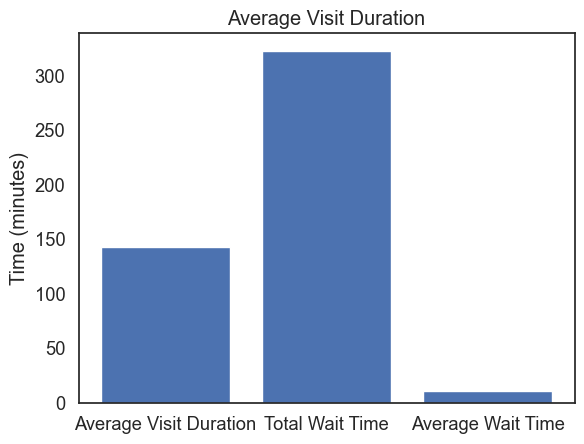

In [135]:
#Create bar chart for each scenario and talk about findings

import matplotlib.pyplot as plt

# Number of trucks waited
num_trucks_waited = truckFrame['Waiting_on_Team_Duration'].astype(bool).sum()

# Average wait time
avg_wait_time = truckFrame['Waiting_on_Team_Duration'].mean()

# Average visit duration
avg_visit_duration = truckFrame['Total_Visit_Duration'].mean()

# Total Wait Time of All Trucks
total_wait_time = truckFrame['Waiting_on_Team_Duration'].sum()

# Create the average visit duration plot
plt.bar(['Average Visit Duration', 'Total Wait Time','Average Wait Time'],
        [avg_visit_duration, total_wait_time,avg_wait_time])
plt.ylabel('Time (minutes)')
plt.title('Average Visit Duration')
savefig(f'{shp_trucks_that_day}Truck{shp_team_no}Team - Avg Visit Duration and Total Wait Time.pdf')
plt.show()

Saving figure to file 30Truck2Team - Num of Trucks Waited and Average.pdf


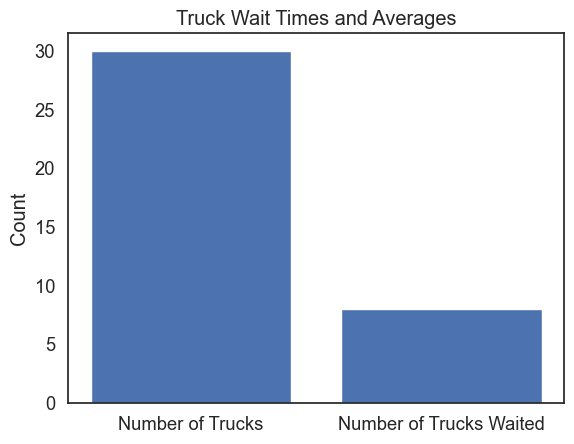

In [136]:
plt.bar(['Number of Trucks','Number of Trucks Waited'],
        [shp_trucks_that_day,num_trucks_waited])
plt.ylabel('Count')
plt.title('Truck Wait Times and Averages')
savefig(f'{shp_trucks_that_day}Truck{shp_team_no}Team - Num of Trucks Waited and Average.pdf')
plt.show()

In [ ]:
#Print out some dataframes

from IPython.display import display

# Display the dataframe

display(Teams2Trucks10)
display(Teams2Trucks15)
display(Teams2Trucks20)
display(Teams2Trucks25)
display(Teams2Trucks30)

display(Teams3Trucks10)
display(Teams3Trucks15)
display(Teams3Trucks20)
display(Teams3Trucks25)
display(Teams3Trucks30)

In [ ]:
import pandas as pd

# Export dataframe to Excel
Teams2Trucks10.to_excel('Truck10Teams2.xlsx', index=False)
Teams2Trucks15.to_excel('Truck15Teams2.xlsx', index=False)
Teams2Trucks20.to_excel('Truck20Teams2.xlsx', index=False)
Teams2Trucks25.to_excel('Truck25Teams2.xlsx', index=False)
Teams2Trucks30.to_excel('Truck30Teams2.xlsx', index=False)

Teams3Trucks10.to_excel('Truck10Teams3.xlsx', index=False)
Teams3Trucks15.to_excel('Truck15Teams3.xlsx', index=False)
Teams3Trucks20.to_excel('Truck20Teams3.xlsx', index=False)
Teams3Trucks25.to_excel('Truck25Teams3.xlsx', index=False)
Teams3Trucks30.to_excel('Truck30Teams3.xlsx', index=False)